In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import evds as e
from pymannkendall import original_test
from statsmodels.graphics.tsaplots import month_plot
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
with open("api_key.txt", "r") as f:
    api_key = f.read()
    
evds = e.evdsAPI(api_key)

In [3]:
data = evds.get_data(["TP.ELEKTUKETIM.TKT1"], startdate = "01-01-2016", enddate = "31-12-2023", frequency = 5)
data.head()

,Tarih,TP_ELEKTUKETIM_TKT1
0,2016-1,765344.606452
1,2016-2,729419.478621
2,2016-3,714857.482581
3,2016-4,710060.789333
4,2016-5,706461.367097


In [4]:
data["Tarih"] = pd.date_range("01.01.2016", periods=len(data), freq="M")
data.set_index("Tarih", inplace = True)
data.columns = ["Tüketim"]
data.head()

,Tüketim
Tarih,
2016-01-31,765344.606452
2016-02-29,729419.478621
2016-03-31,714857.482581
2016-04-30,710060.789333
2016-05-31,706461.367097


In [5]:
data.isnull().sum()

Tüketim    0
dtype: int64

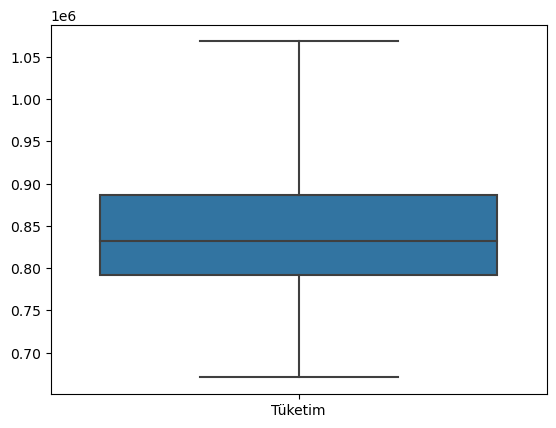

In [6]:
sns.boxplot(data, whis = 3)
plt.show();

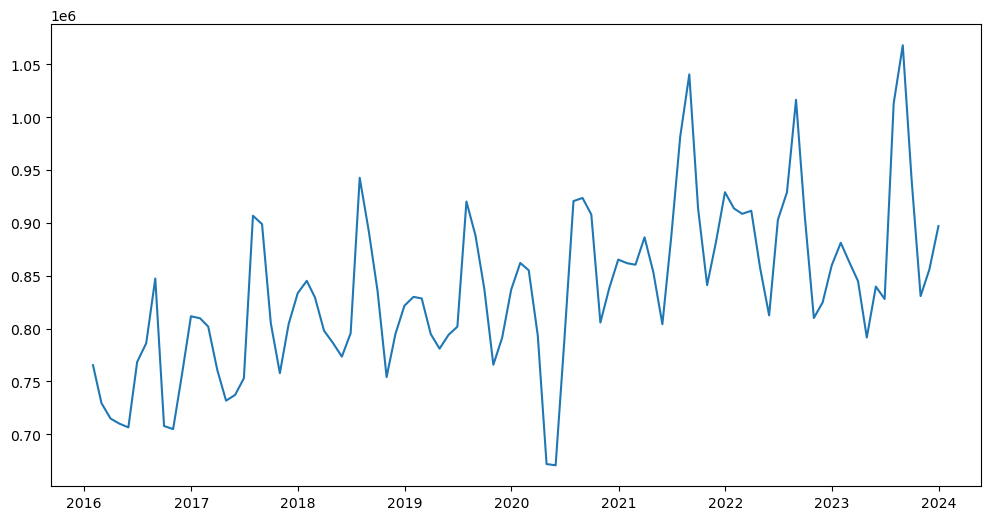

In [7]:
plt.figure(figsize = (12,6))
plt.plot(data)
plt.show();

In [8]:
# Mevsimsellik ve trend var görünse de test edelim.

print(original_test(data)) # trend testi

Mann_Kendall_Test(trend='increasing', h=True, p=1.2469851817797917e-09, z=6.07408262171593, Tau=0.42105263157894735, s=1920.0, var_s=99813.33333333333, slope=1581.4926249511102, intercept=756975.5411212739)


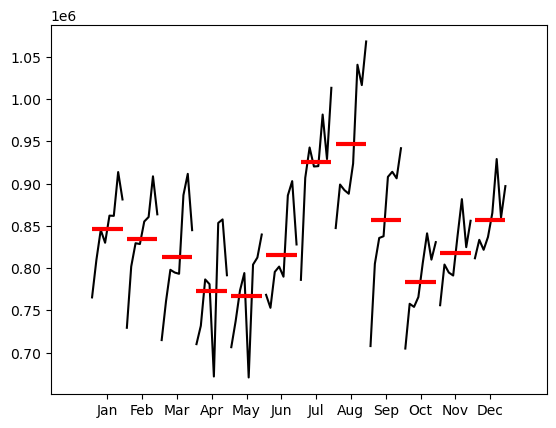

In [9]:
# mevimselliğin grafik ile testi

month_plot(data)
plt.show();

In [10]:
# Yaz aylarında maks tüketim olmakla birlikte bahar aylarında düşmeye başlar ve kışa doğru tekrar yükselmeye başlar.
# Seride mevimsellik ve trend bulunmaktadır, bu sebeple Triple Exponential Smoothing yöntemi kullanılabilir.

In [11]:
# Son 12 aylık veri tahmin edileceği için seriden çıkaralım

data_new = data.iloc[:-12]
last_year = data.iloc[-12:]

print(data_new)
print(last_year)

                 Tüketim
Tarih                   
2016-01-31  7.653446e+05
2016-02-29  7.294195e+05
2016-03-31  7.148575e+05
2016-04-30  7.100608e+05
2016-05-31  7.064614e+05
...                  ...
2022-08-31  1.016522e+06
2022-09-30  9.062296e+05
2022-10-31  8.100255e+05
2022-11-30  8.247804e+05
2022-12-31  8.597678e+05

[84 rows x 1 columns]
                 Tüketim
Tarih                   
2023-01-31  8.812087e+05
2023-02-28  8.636199e+05
2023-03-31  8.448948e+05
2023-04-30  7.915435e+05
2023-05-31  8.397370e+05
2023-06-30  8.279880e+05
2023-07-31  1.013276e+06
2023-08-31  1.068113e+06
2023-09-30  9.418227e+05
2023-10-31  8.307328e+05
2023-11-30  8.559926e+05
2023-12-31  8.970247e+05


In [12]:
params = {
    "trend": ["add", "mul"],
    "damped_trend": [True, False],
    "seasonal": ["add", "mul"],
    "smoothing_level": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    "smoothing_trend": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    "smoothing_seasonal": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    "damping_trend": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

pg = list(ParameterGrid(param_grid = params))
df = pd.DataFrame(pg)
df.head()

,damped_trend,damping_trend,seasonal,smoothing_level,smoothing_seasonal,smoothing_trend,trend
0,True,0.1,add,0.1,0.1,0.1,add
1,True,0.1,add,0.1,0.1,0.1,mul
2,True,0.1,add,0.1,0.1,0.2,add
3,True,0.1,add,0.1,0.1,0.2,mul
4,True,0.1,add,0.1,0.1,0.3,add


In [13]:
rmse = []

for i in range(len(df)):
    tes = ExponentialSmoothing(data_new, 
                               trend = df.loc[i,"trend"], 
                               damped_trend = df.loc[i,"damped_trend"], 
                               seasonal = df.loc[i,"seasonal"], 
                               seasonal_periods = 12)
    
    model = tes.fit(smoothing_level = df.loc[i,"smoothing_level"], 
                    smoothing_trend = df.loc[i,"smoothing_trend"], 
                    smoothing_seasonal = df.loc[i,"smoothing_seasonal"], 
                    damping_trend = df.loc[i,"damped_trend"], 
                    optimized = False)
    
    gecmis_tahmin = model.fittedvalues
    rmse.append(mean_squared_error(data_new, gecmis_tahmin, squared = False))
    
df["RMSE"] = rmse


       damped_trend  damping_trend seasonal  smoothing_level  \
9234           True            0.4      add              0.4   
3402           True            0.2      add              0.4   
486            True            0.1      add              0.4   
6318           True            0.3      add              0.4   
41310         False            0.6      add              0.4   

       smoothing_seasonal  smoothing_trend trend          RMSE  
9234                  0.1              0.1   add  32736.444035  
3402                  0.1              0.1   add  32736.444035  
486                   0.1              0.1   add  32736.444035  
6318                  0.1              0.1   add  32736.444035  
41310                 0.1              0.1   add  32736.444035  


In [14]:
print(df.sort_values(["RMSE"]).head(1))

      damped_trend  damping_trend seasonal  smoothing_level  \
9234          True            0.4      add              0.4   

      smoothing_seasonal  smoothing_trend trend          RMSE  
9234                 0.1              0.1   add  32736.444035  


In [15]:
tes = ExponentialSmoothing(data_new, 
                            trend = "add", 
                            damped_trend = True, 
                            seasonal = "add", 
                            seasonal_periods = 12)
    
model = tes.fit(smoothing_level = 0.4, 
                smoothing_trend = 0.1, 
                smoothing_seasonal = 0.1, 
                damping_trend = 0.4, 
                optimized = False)

gecmis_tahmin = model.fittedvalues

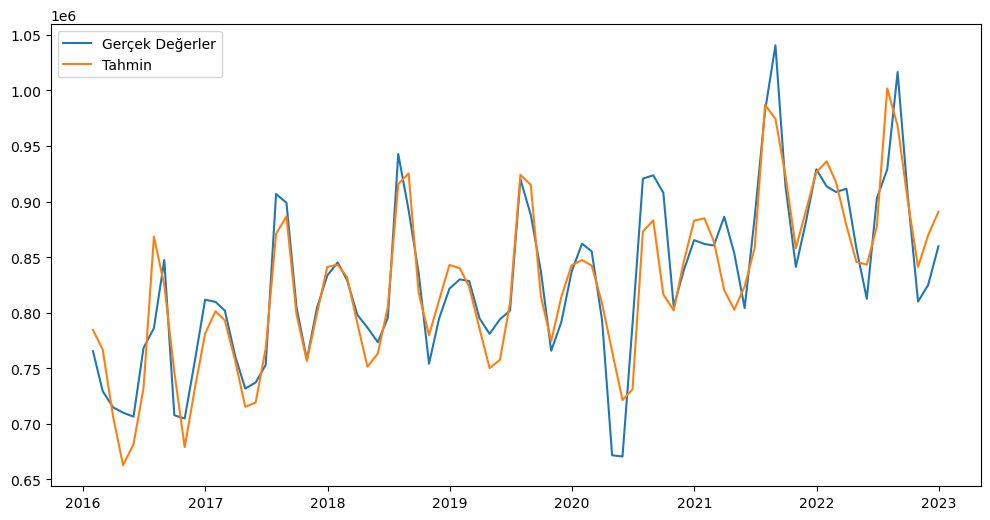

In [16]:
plt.figure(figsize = (12,6))
plt.plot(data_new, label = "Gerçek Değerler")
plt.plot(gecmis_tahmin, label = "Tahmin")
plt.legend()
plt.show();

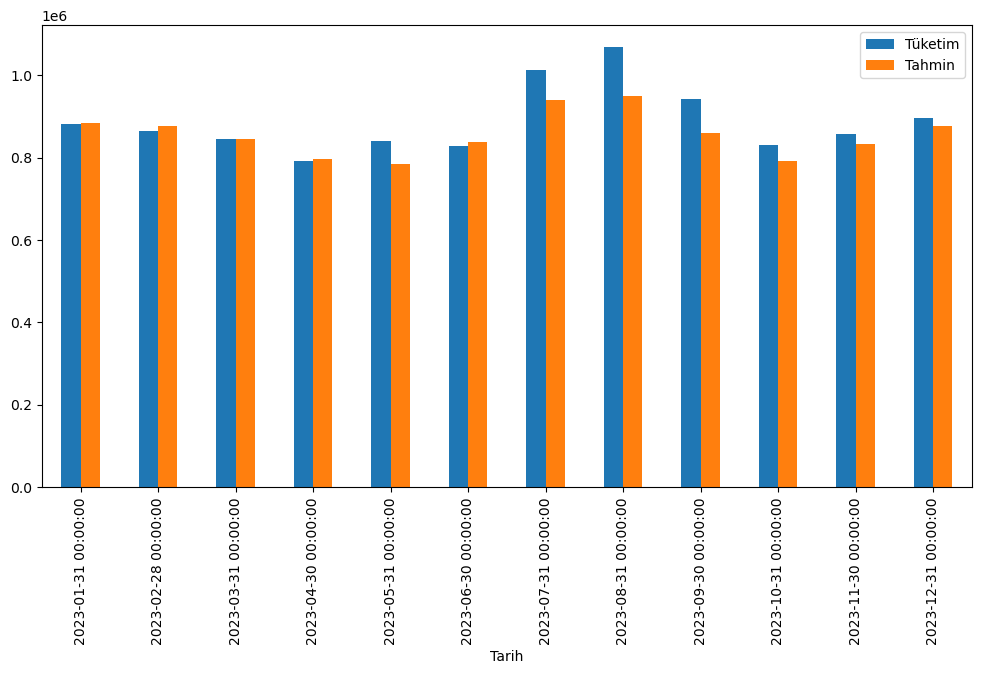

In [19]:
gelecek_tahmin = model.forecast(12)
last_year["Tahmin"] = gelecek_tahmin
last_year.plot(kind = "bar", figsize=(12,6))
plt.show();